In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59dc8000 @  0x7fe3df0381c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.7MB/s 
    100% |████████████████████████████████| 2.0MB 6.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

In [14]:
class LinearNetwork(nn.Module):
  def __init__(self, dataset):
    super(LinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out = y.size(0)
    
    self.net = nn.Sequential(nn.Linear(c * h * w, out))
    
  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c * h * w)
    return self.net(flattened)
  
  
class FashionMNISTProcessedData(Dataset):
   def __init__(self, root, train=True):
      self.data = datasets.FashionMNIST(root,
                                       train=train,
                                       transform = transforms.ToTensor(),
                                       download=True)
   def __getitem__(self, i):
    x, y = self.data[i]
    return x, y.unsqueeze(0).float()
    
      
   def __len__(self):
    return len(self.data)

train_dataset = FashionMNISTProcessedData('/tmp/fashionnmist', True)    
    
model = LinearNetwork(train_dataset)
model = model.cuda()
objective = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset,
                         batch_size=42,
                         pin_memory=True)

training_losses = []
validation_losses = []

for epoch in range(2):
  
  loop = tqdm(total=len(train_loader), position=0)
  print(len(train_loader))
  for i,(x,y_truth) in enumerate(train_loader):
    x = x.cuda(async=True)
    y_truth = y_truth.cuda(async=True )

    optimizer.zero_grad()

    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    
    training_losses.append(loss)
    
    loop.set_description('loss:{:.4f}'.format(loss.item()))
    loop.update(1)
    
    loss.backward()
    
    optimizer.step()
    
    if(i== 0 or i == 714 or i == 1428):
      validation_loss = []
      validation_dataset = FashionMNISTProcessedData('/tmp/fashionnmist', False)
      validation_loader = DataLoader(validation_dataset,
                               batch_size=42,
                               pin_memory=True)

      val_loop = tqdm(total=len(validation_loader), position=0)

      for val_x1,val_y1_truth in validation_loader:

        val_x1 = val_x1.cuda(async=True)
        val_y1_truth = val_y1_truth.cuda(async=True )

        val_y1_hat = model(val_x1)
        v_loss = objective(val_y1_hat, val_y1_truth)

        validation_loss.append(v_loss)

        val_loop.set_description('V loss:{:.4f}'.format(v_loss.item()))
        val_loop.update(1)

      val_loss = [x.item() for x in validation_loss]
      validation_losses.append(sum(val_loss)/len(val_loss))
      val_loop.close()
      

  loop.close()
  
  

V loss:25.8441:   6%|▋         | 15/239 [00:00<00:02, 98.06it/s]

1429


V loss:3.6370:   6%|▌         | 14/239 [00:00<00:02, 89.13it/s]

1429


loss:2.6420: 100%|██████████| 1429/1429 [00:25<00:00, 56.16it/s]


In [58]:
print(len(validation_losses))

6


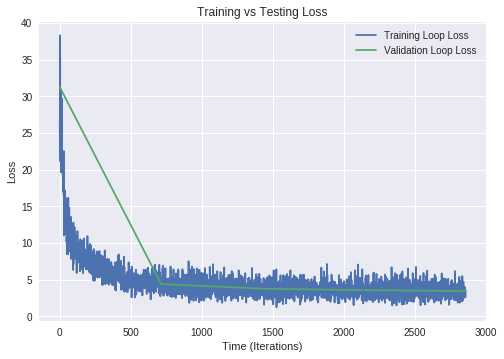

In [15]:
"""
-------Ploting the Training vs the Testing loop losses---------
"""

import matplotlib.pyplot as plt
import numpy as np

train_losses = [x.item() for x in training_losses]
val_losses = validation_losses

plt.plot(range(0,2858), train_losses)
plt.plot([0, 714, 1429, 1430 ,2143, 2857],val_losses)

plt.xlabel('Time (Iterations)')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss')
plt.grid(True)
plt.savefig("test.png")
plt.legend(["Training Loop Loss", "Validation Loop Loss"])
plt.show()

In [11]:
"""
------------This is The overfitting part------------
"""
class OVLinearNetwork(nn.Module):
  def __init__(self, dataset):
    super(OVLinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out = y.size(0)
    
    self.net = nn.Sequential(nn.Linear(c * h * w, 1000),
                            nn.Sigmoid(),
                            nn.Linear(1000, out))
    
  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c * h * w)
    return self.net(flattened)
  

class OverFitFashionMNISTProcessedData(Dataset):
   def __init__(self, root, train=True):
      self.data = datasets.FashionMNIST(root,
                                       train=train,
                                       transform = transforms.ToTensor(),
                                       download=True)
   def __getitem__(self, i):
    x, y = self.data[i]
    return x, y.unsqueeze(0).float()
    
      
   def __len__(self):
    return 42

overfit_train_dataset = OverFitFashionMNISTProcessedData('/tmp/fashionnmist', True)    
    
model = OVLinearNetwork(overfit_train_dataset)
model = model.cuda()
objective = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
overfit_train_loader = DataLoader(overfit_train_dataset,
                         batch_size=42,
                         pin_memory=True)

overift_training_losses = []
ov_validation_losses = []

for epoch in range(30):
  
  loop = tqdm(total=len(overfit_train_loader), position=0)
  
  for x,y_truth in overfit_train_loader:
    
    x = x.cuda(async=True)
    y_truth = y_truth.cuda(async=True )

    optimizer.zero_grad()

    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    
    overift_training_losses.append(loss)
    
    loop.set_description('loss:{:.4f}'.format(loss.item()))
    loop.update(1)
    
    loss.backward()
    
    optimizer.step()
    
  ov_validation_loss = []
  ov_validation_loader = DataLoader(train_dataset,
                           batch_size=42,
                           pin_memory=True)

  ov_val_loop = tqdm(total=len(ov_validation_loader), position=0)

  for ov_x1,ov_y1_truth in ov_validation_loader:

    ov_x1 = ov_x1.cuda(async=True)
    ov_y1_truth = ov_y1_truth.cuda(async=True )

    ov_y1_hat = model(ov_x1)
    ov_v_loss = objective(ov_y1_hat, ov_y1_truth)

    ov_validation_loss.append(ov_v_loss)

    ov_val_loop.set_description('V loss:{:.4f}'.format(ov_v_loss.item()))
    ov_val_loop.update(1)

  ov_val_loss = [x.item() for x in ov_validation_loss]
  ov_validation_losses.append(sum(ov_val_loss)/len(ov_val_loss))
  ov_val_loop.close()
    
  loop.close()

V loss:19.9155:  51%|█████     | 729/1429 [00:09<00:09, 77.36it/s]

KeyboardInterrupt: ignored

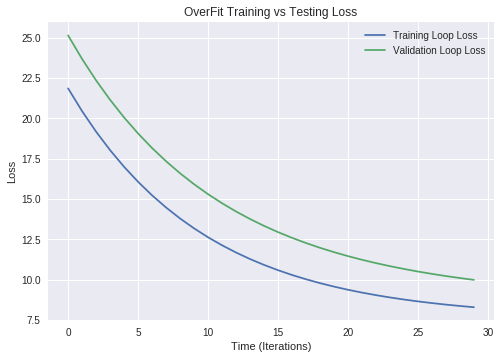

In [10]:
over_train_losses = [x.item() for x in overift_training_losses]
plt.plot(over_train_losses)

x_vals = range(30)
  
  
plt.plot(x_vals,ov_validation_losses)


plt.xlabel('Time (Iterations)')
plt.ylabel('Loss')
plt.title('OverFit Training vs Testing Loss')
plt.grid(True)
plt.savefig("test.png")
plt.legend(["Training Loop Loss","Validation Loop Loss"])
plt.show()